# Jan 13th, 2021 (topo dist, best density)

**Motivation**: Applied to $128*0$ and $256*0$  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def collect_adjacencies(mice, mode):
    proc, *_ = mice.get_data_containers(mode)

    adjacencies, dirs = [], {}
    for key in proc:
        sub, ses, run = mice.looper[key]
        if run == -1:
            continue
        net = Network(mice, key, mode).load_network()
        adjacencies.append(np.expand_dims(net.adj, 0))
        dirs[key] = pjoin(mice.cfg.results_dir, 'Network', net.base_name)

    adjacencies = np.concatenate(adjacencies)
    return adjacencies, dirs


def calculate_portraits(adj, thres, save_dir=None):
    portraits = {}
    nonzero = np.abs(adj).mean(0) > 0
    for i, th in enumerate(thres):
        adj_eff = adj[nonzero][:, nonzero]
        adj_eff[adj_eff <= th] = 0.
        g = nx.from_numpy_matrix(adj_eff)
        if save_dir is not None:
            fname = f"{'_'.join(save_dir.split('_')[-3:])}_no{i:03d}_th{th:0.7f}"
        else:
            fname = None
        portraits[(i, th)] = portrait_cpp(g, fname)

    if save_dir is not None:
        save_obj(
            obj=portraits,
            file_name='portraits',
            save_dir=save_dir,
            mode='npy',
            verbose=False,
        )
    return portraits


def calculate_portrait_divergece(portraits_list):
    div = np_nans((len(portraits_list), len(portraits_list)))
    for i, j in itertools.combinations(range(len(portraits_list)), 2):
        div[i, j] = portrait_divergence(portraits_list[i], portraits_list[j])
    return div

In [3]:
sys.path.insert(0, pjoin(git_dir, 'network-portrait-divergence'))
from portrait_divergence import portrait_divergence, portrait_py, portrait_cpp

## 128*0

In [4]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

### Bold-lite

In [5]:
adjacencies, dirs = collect_adjacencies(mice, 'bold-lite')
adjacencies.shape

(114, 174, 174)

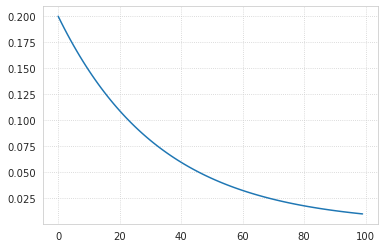

In [7]:
start = 0.20
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
plt.plot(densities);

In [8]:
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [9]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portraits)
        (adjacencies[i], thresholds[i], list(dirs.values())[i])
        for i in range(len(adjacencies))
    )

CPU times: user 1.28 s, sys: 2.02 s, total: 3.3 s
Wall time: 15.4 s


In [10]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [11]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    div_list = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portrait_divergece)
        ([v[di] for v in portraits.values()])
        for di in range(len(densities))
    )
    
div = np_nans((len(densities), len(adjacencies), len(adjacencies)))
for di in range(len(densities)):
    div[di] = div_list[di]

CPU times: user 1.05 s, sys: 1.91 s, total: 2.96 s
Wall time: 10.2 s


In [12]:
run_ids = {}
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        _k = mice.get_key(sub, ses)
        run_ids[_k] = [
            i for i, k in enumerate(dirs)
            if _k in k
        ]

within_ids = collections.defaultdict(list)
for _k, ids in run_ids.items():
    for i, j in itertools.combinations(range(len(ids)), 2):
        within_ids[_k].append((ids[i], ids[j]))

across_ids = collections.defaultdict(list)
for sub in mice.cfg.sub_ids:
    for a, b in itertools.combinations(mice.cfg.ses_ids, 2):
        ka = mice.get_key(sub, a)
        kb = mice.get_key(sub, b)
        ids_a = run_ids[ka]
        ids_b = run_ids[kb]
        across_ids[f"sub{sub}_ses{a}v{b}"] = list(itertools.product(ids_a, ids_b))
        
within_ids = dict(within_ids)
across_ids = dict(across_ids)

In [13]:
estimator = np.mean
dlist = []
for di, d in enumerate(densities):
    for _k, ids in within_ids.items():
        data = div[di][list(zip(*ids))]
        sub = mice.looper[_k][0]
        dlist.append({
            'subject': [sub] * len(data),
            'condition': ['within'] * len(data),
            'density': [d] * len(data),
            'label': [_k] * len(data),
            'val': data,
            'ids': ids,
        })
    for _k, ids in across_ids.items():
        data = div[di][list(zip(*ids))]
        sub = re.findall(r"\d+", _k.split('_')[0])
        sub = next(map(int, sub))
        dlist.append({
            'subject': [sub] * len(data),
            'condition': ['across'] * len(data),
            'density': [d] * len(data),
            'label': [_k] * len(data),
            'val': data,
            'ids': ids,
        })
df = pd.DataFrame(merge_dicts(dlist))
_df = df.groupby(['subject', 'condition', 'density']).mean()
_df.reset_index(inplace=True)

In [14]:
df_avg = df.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

best_d, min_div

(0.1309320464436578, 0.3632201230880475)

In [15]:
_df_avg = _df.groupby(['density']).mean()
_df_avg = _df_avg['val']
best_i = np.argmin(_df_avg.values)
best_d, min_div = _df_avg.index[best_i], _df_avg.values[best_i]

best_d, min_div

(0.1309320464436578, 0.36382424138527214)

In [16]:
_df_avg = _df.loc[_df['condition'] == 'within']
_df_avg = _df_avg.groupby(['density']).mean()
_df_avg = _df_avg['val']
best_i = np.argmin(_df_avg.values)
best_d, min_div = _df_avg.index[best_i], _df_avg.values[best_i]

best_d, min_div

(0.1309320464436578, 0.3633993036156284)

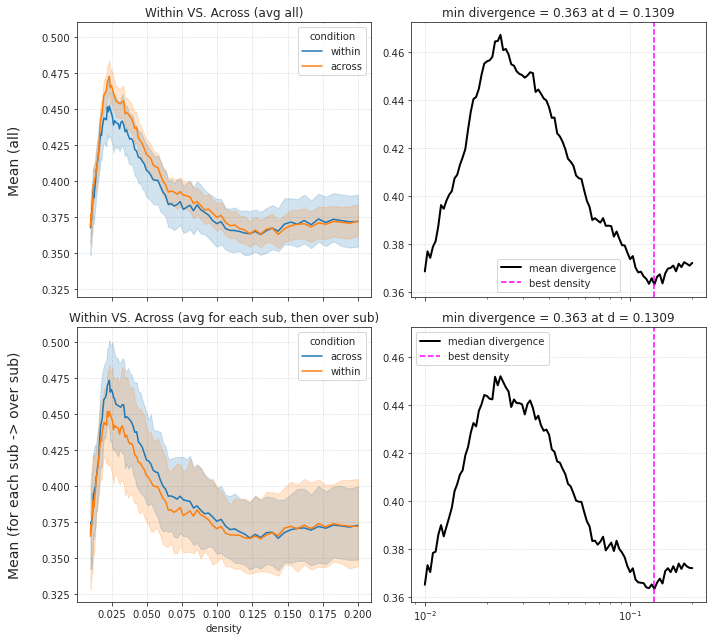

In [17]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df.loc[df['condition'] == 'within']
df_avg = df.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df,
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = _df.loc[_df['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=_df,
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [18]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(14, 0.1309320464436578)

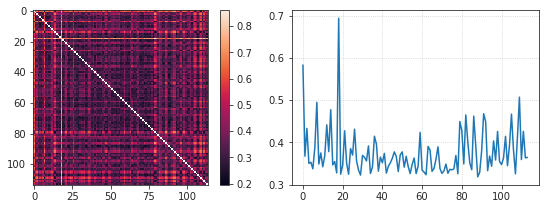

In [19]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [20]:
bad_runs_bold = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs_bold = [list(dirs)[i] for i in bad_runs_bold]
bad_runs_bold

[
    'sub-SLC02_ses-2_run-5',
    'sub-SLC01_ses-1_run-1',
    'sub-SLC10_ses-2_run-7',
    'sub-SLC01_ses-2_run-7',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC09_ses-1_run-1',
    'sub-SLC10_ses-1_run-5',
    'sub-SLC08_ses-1_run-5',
    'sub-SLC08_ses-2_run-7',
    'sub-SLC07_ses-3_run-5'
]

In [21]:
from sklearn.manifold import TSNE, MDS

In [22]:
x[np.isnan(x)] = 0.

In [23]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [24]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
_df['sub'] = subs
_df['ses'] = sess
_df['run'] = runs

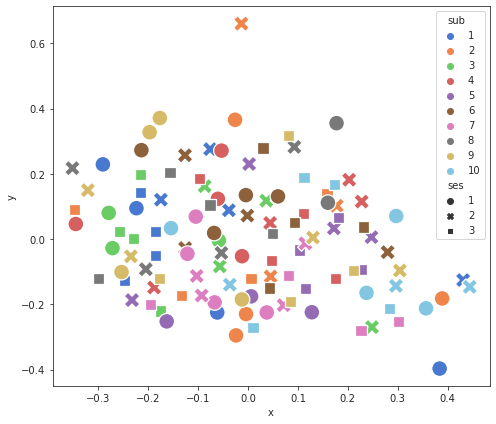

In [25]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='sub',
    palette='muted',
    style='ses',
    alpha=1.0,
    s=250,
    ax=ax,
)
plt.show()

In [26]:
x_emb = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [27]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
_df['sub'] = subs
_df['ses'] = sess
_df['run'] = runs

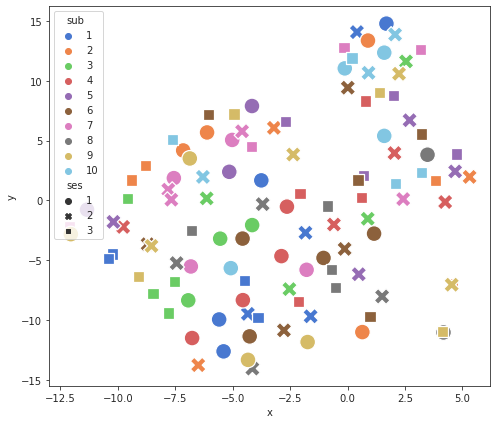

In [28]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='sub',
    palette='muted',
    style='ses',
    alpha=1.0,
    s=250,
    ax=ax,
)
plt.show()

### Ca2

In [29]:
adjacencies, dirs = collect_adjacencies(mice, 'ca2')
adjacencies.shape

(118, 174, 174)

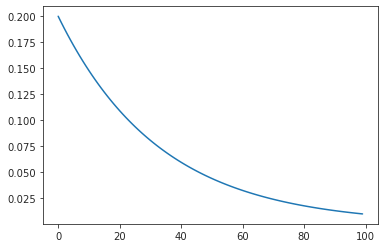

In [30]:
start = 0.20
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
plt.plot(densities);

In [31]:
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [32]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portraits)
        (adjacencies[i], thresholds[i], list(dirs.values())[i])
        for i in range(len(adjacencies))
    )

CPU times: user 1.36 s, sys: 2.35 s, total: 3.71 s
Wall time: 13.6 s


In [33]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [34]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    div_list = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portrait_divergece)
        ([v[di] for v in portraits.values()])
        for di in range(len(densities))
    )
    
div = np_nans((len(densities), len(adjacencies), len(adjacencies)))
for di in range(len(densities)):
    div[di] = div_list[di]

CPU times: user 1.19 s, sys: 2.17 s, total: 3.36 s
Wall time: 10.7 s


In [35]:
run_ids = {}
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        _k = mice.get_key(sub, ses)
        run_ids[_k] = [
            i for i, k in enumerate(dirs)
            if _k in k
        ]

within_ids = collections.defaultdict(list)
for _k, ids in run_ids.items():
    for i, j in itertools.combinations(range(len(ids)), 2):
        within_ids[_k].append((ids[i], ids[j]))

across_ids = collections.defaultdict(list)
for sub in mice.cfg.sub_ids:
    for a, b in itertools.combinations(mice.cfg.ses_ids, 2):
        ka = mice.get_key(sub, a)
        kb = mice.get_key(sub, b)
        ids_a = run_ids[ka]
        ids_b = run_ids[kb]
        across_ids[f"sub{sub}_ses{a}v{b}"] = list(itertools.product(ids_a, ids_b))
        
within_ids = dict(within_ids)
across_ids = dict(across_ids)

In [36]:
estimator = np.mean
dlist = []
for di, d in enumerate(densities):
    for _k, ids in within_ids.items():
        data = div[di][list(zip(*ids))]
        sub = mice.looper[_k][0]
        dlist.append({
            'subject': [sub] * len(data),
            'condition': ['within'] * len(data),
            'density': [d] * len(data),
            'label': [_k] * len(data),
            'val': data,
            'ids': ids,
        })
    for _k, ids in across_ids.items():
        data = div[di][list(zip(*ids))]
        sub = re.findall(r"\d+", _k.split('_')[0])
        sub = next(map(int, sub))
        dlist.append({
            'subject': [sub] * len(data),
            'condition': ['across'] * len(data),
            'density': [d] * len(data),
            'label': [_k] * len(data),
            'val': data,
            'ids': ids,
        })
df = pd.DataFrame(merge_dicts(dlist))
_df = df.groupby(['subject', 'condition', 'density']).mean()
_df.reset_index(inplace=True)

In [37]:
df_avg = df.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

best_d, min_div

(0.09106371221023628, 0.30922662138940016)

In [38]:
_df_avg = _df.groupby(['density']).mean()
_df_avg = _df_avg['val']
best_i = np.argmin(_df_avg.values)
best_d, min_div = _df_avg.index[best_i], _df_avg.values[best_i]

best_d, min_div

(0.09106371221023628, 0.30933198206989265)

In [39]:
_df_avg = _df.loc[_df['condition'] == 'within']
_df_avg = _df_avg.groupby(['density']).mean()
_df_avg = _df_avg['val']
best_i = np.argmin(_df_avg.values)
best_d, min_div = _df_avg.index[best_i], _df_avg.values[best_i]

best_d, min_div

(0.0714844554717933, 0.30420433312863693)

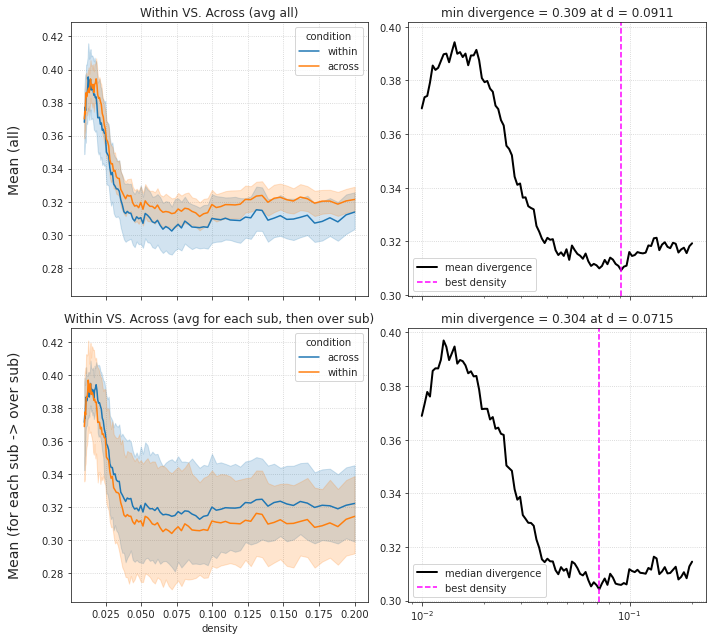

In [40]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df.loc[df['condition'] == 'within']
df_avg = df.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df,
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = _df.loc[_df['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=_df,
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [41]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(34, 0.0714844554717933)

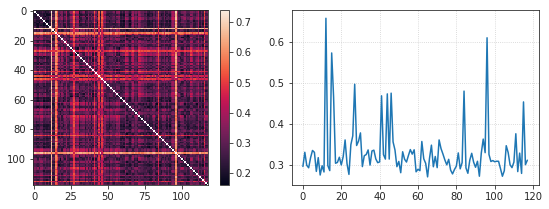

In [42]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [43]:
bad_runs_bold = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs_bold = [list(dirs)[i] for i in bad_runs_bold]
bad_runs_bold

[
    'sub-SLC02_ses-1_run-1',
    'sub-SLC09_ses-1_run-5',
    'sub-SLC02_ses-1_run-7',
    'sub-SLC03_ses-2_run-1',
    'sub-SLC08_ses-1_run-3',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC04_ses-3_run-3',
    'sub-SLC04_ses-2_run-5',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC10_ses-3_run-3'
]

In [44]:
from sklearn.manifold import TSNE, MDS

In [45]:
x[np.isnan(x)] = 0.

In [46]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [47]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
_df['sub'] = subs
_df['ses'] = sess
_df['run'] = runs

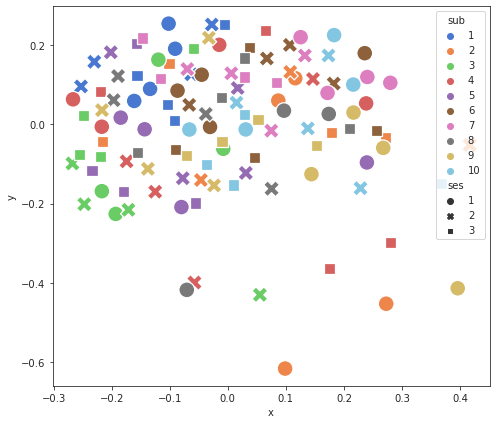

In [48]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='sub',
    palette='muted',
    style='ses',
    alpha=1.0,
    s=250,
    ax=ax,
)
plt.show()

In [49]:
x_emb = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [50]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
_df['sub'] = subs
_df['ses'] = sess
_df['run'] = runs

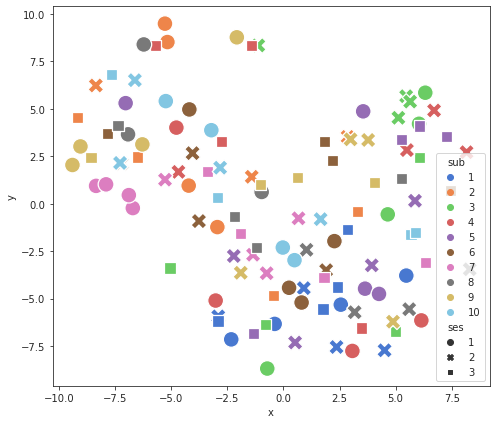

In [51]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='sub',
    palette='muted',
    style='ses',
    alpha=1.0,
    s=250,
    ax=ax,
)
plt.show()

## 256*0

In [52]:
mice = Mice((256, 0, 100))
mice.setup_func_data('rest')

### Bold-lite

In [53]:
adjacencies, dirs = collect_adjacencies(mice, 'bold-lite')
adjacencies.shape

(114, 312, 312)

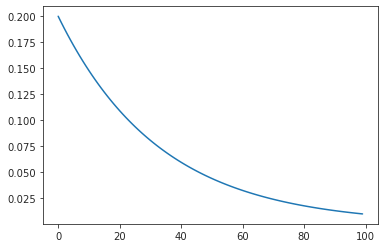

In [54]:
start = 0.20
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
plt.plot(densities);

In [55]:
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [56]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portraits)
        (adjacencies[i], thresholds[i], list(dirs.values())[i])
        for i in range(len(adjacencies))
    )

CPU times: user 1.84 s, sys: 3.23 s, total: 5.07 s
Wall time: 51.4 s


In [57]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [58]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    div_list = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portrait_divergece)
        ([v[di] for v in portraits.values()])
        for di in range(len(densities))
    )
    
div = np_nans((len(densities), len(adjacencies), len(adjacencies)))
for di in range(len(densities)):
    div[di] = div_list[di]

CPU times: user 1.76 s, sys: 2.96 s, total: 4.72 s
Wall time: 16.1 s


In [59]:
run_ids = {}
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        _k = mice.get_key(sub, ses)
        run_ids[_k] = [
            i for i, k in enumerate(dirs)
            if _k in k
        ]

within_ids = collections.defaultdict(list)
for _k, ids in run_ids.items():
    for i, j in itertools.combinations(range(len(ids)), 2):
        within_ids[_k].append((ids[i], ids[j]))

across_ids = collections.defaultdict(list)
for sub in mice.cfg.sub_ids:
    for a, b in itertools.combinations(mice.cfg.ses_ids, 2):
        ka = mice.get_key(sub, a)
        kb = mice.get_key(sub, b)
        ids_a = run_ids[ka]
        ids_b = run_ids[kb]
        across_ids[f"sub{sub}_ses{a}v{b}"] = list(itertools.product(ids_a, ids_b))
        
within_ids = dict(within_ids)
across_ids = dict(across_ids)

In [60]:
estimator = np.mean
dlist = []
for di, d in enumerate(densities):
    for _k, ids in within_ids.items():
        data = div[di][list(zip(*ids))]
        sub = mice.looper[_k][0]
        dlist.append({
            'subject': [sub] * len(data),
            'condition': ['within'] * len(data),
            'density': [d] * len(data),
            'label': [_k] * len(data),
            'val': data,
            'ids': ids,
        })
    for _k, ids in across_ids.items():
        data = div[di][list(zip(*ids))]
        sub = re.findall(r"\d+", _k.split('_')[0])
        sub = next(map(int, sub))
        dlist.append({
            'subject': [sub] * len(data),
            'condition': ['across'] * len(data),
            'density': [d] * len(data),
            'label': [_k] * len(data),
            'val': data,
            'ids': ids,
        })
df = pd.DataFrame(merge_dicts(dlist))
_df = df.groupby(['subject', 'condition', 'density']).mean()
_df.reset_index(inplace=True)

In [61]:
df_avg = df.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

best_d, min_div

(0.09386140859616947, 0.39002733515678484)

In [62]:
_df_avg = _df.groupby(['density']).mean()
_df_avg = _df_avg['val']
best_i = np.argmin(_df_avg.values)
best_d, min_div = _df_avg.index[best_i], _df_avg.values[best_i]

best_d, min_div

(0.09386140859616947, 0.3902545616184944)

In [63]:
_df_avg = _df.loc[_df['condition'] == 'within']
_df_avg = _df_avg.groupby(['density']).mean()
_df_avg = _df_avg['val']
best_i = np.argmin(_df_avg.values)
best_d, min_div = _df_avg.index[best_i], _df_avg.values[best_i]

best_d, min_div

(0.09386140859616947, 0.39034435819408336)

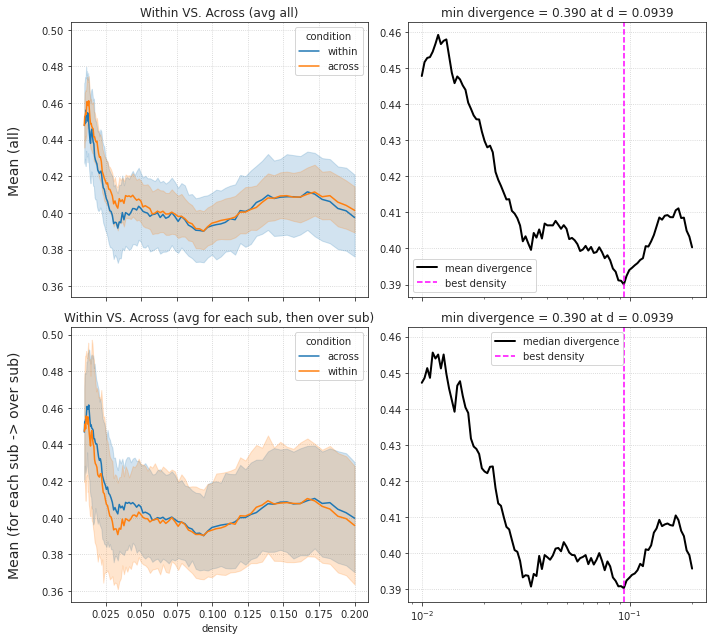

In [64]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df.loc[df['condition'] == 'within']
df_avg = df.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df,
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = _df.loc[_df['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=_df,
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [65]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(25, 0.09386140859616947)

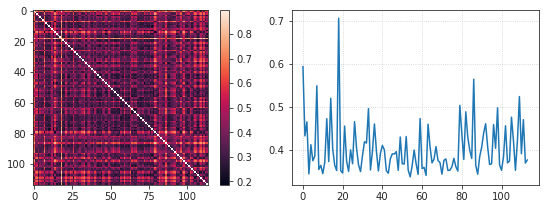

In [66]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [67]:
bad_runs_bold = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs_bold = [list(dirs)[i] for i in bad_runs_bold]
bad_runs_bold

[
    'sub-SLC02_ses-2_run-5',
    'sub-SLC01_ses-1_run-1',
    'sub-SLC08_ses-2_run-7',
    'sub-SLC01_ses-2_run-7',
    'sub-SLC10_ses-2_run-7',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC07_ses-3_run-5',
    'sub-SLC09_ses-2_run-7',
    'sub-SLC03_ses-3_run-7',
    'sub-SLC08_ses-1_run-5'
]

In [68]:
from sklearn.manifold import TSNE, MDS

In [69]:
x[np.isnan(x)] = 0.

In [70]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [71]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
_df['sub'] = subs
_df['ses'] = sess
_df['run'] = runs

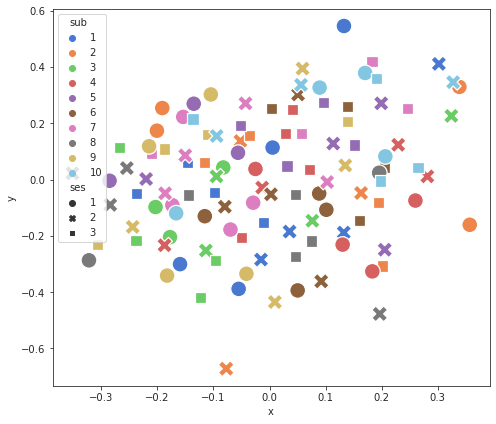

In [72]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='sub',
    palette='muted',
    style='ses',
    alpha=1.0,
    s=250,
    ax=ax,
)
plt.show()

In [73]:
x_emb = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [74]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
_df['sub'] = subs
_df['ses'] = sess
_df['run'] = runs

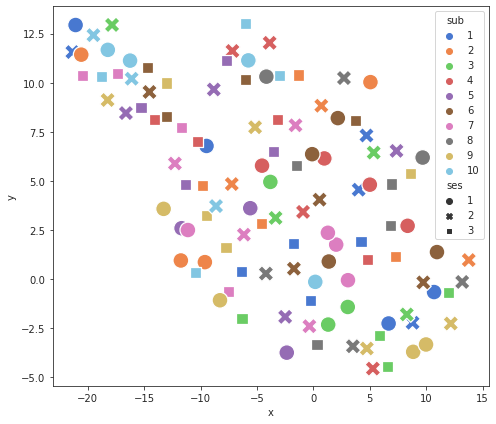

In [75]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='sub',
    palette='muted',
    style='ses',
    alpha=1.0,
    s=250,
    ax=ax,
)
plt.show()

### Ca2

In [76]:
adjacencies, dirs = collect_adjacencies(mice, 'ca2')
adjacencies.shape

(118, 318, 318)

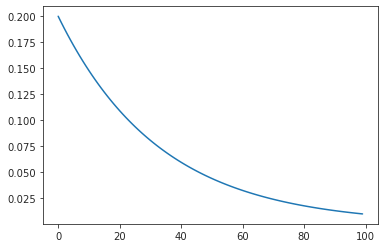

In [77]:
start = 0.20
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
plt.plot(densities);

In [78]:
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [79]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portraits)
        (adjacencies[i], thresholds[i], list(dirs.values())[i])
        for i in range(len(adjacencies))
    )

CPU times: user 1.97 s, sys: 3.29 s, total: 5.26 s
Wall time: 41.9 s


In [80]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [81]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    div_list = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portrait_divergece)
        ([v[di] for v in portraits.values()])
        for di in range(len(densities))
    )
    
div = np_nans((len(densities), len(adjacencies), len(adjacencies)))
for di in range(len(densities)):
    div[di] = div_list[di]

CPU times: user 1.9 s, sys: 3.15 s, total: 5.05 s
Wall time: 15.6 s


In [82]:
run_ids = {}
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        _k = mice.get_key(sub, ses)
        run_ids[_k] = [
            i for i, k in enumerate(dirs)
            if _k in k
        ]

within_ids = collections.defaultdict(list)
for _k, ids in run_ids.items():
    for i, j in itertools.combinations(range(len(ids)), 2):
        within_ids[_k].append((ids[i], ids[j]))

across_ids = collections.defaultdict(list)
for sub in mice.cfg.sub_ids:
    for a, b in itertools.combinations(mice.cfg.ses_ids, 2):
        ka = mice.get_key(sub, a)
        kb = mice.get_key(sub, b)
        ids_a = run_ids[ka]
        ids_b = run_ids[kb]
        across_ids[f"sub{sub}_ses{a}v{b}"] = list(itertools.product(ids_a, ids_b))
        
within_ids = dict(within_ids)
across_ids = dict(across_ids)

In [83]:
estimator = np.mean
dlist = []
for di, d in enumerate(densities):
    for _k, ids in within_ids.items():
        data = div[di][list(zip(*ids))]
        sub = mice.looper[_k][0]
        dlist.append({
            'subject': [sub] * len(data),
            'condition': ['within'] * len(data),
            'density': [d] * len(data),
            'label': [_k] * len(data),
            'val': data,
            'ids': ids,
        })
    for _k, ids in across_ids.items():
        data = div[di][list(zip(*ids))]
        sub = re.findall(r"\d+", _k.split('_')[0])
        sub = next(map(int, sub))
        dlist.append({
            'subject': [sub] * len(data),
            'condition': ['across'] * len(data),
            'density': [d] * len(data),
            'label': [_k] * len(data),
            'val': data,
            'ids': ids,
        })
df = pd.DataFrame(merge_dicts(dlist))
_df = df.groupby(['subject', 'condition', 'density']).mean()
_df.reset_index(inplace=True)

In [84]:
df_avg = df.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

best_d, min_div

(0.04971769751868987, 0.31834451870090624)

In [85]:
_df_avg = _df.groupby(['density']).mean()
_df_avg = _df_avg['val']
best_i = np.argmin(_df_avg.values)
best_d, min_div = _df_avg.index[best_i], _df_avg.values[best_i]

best_d, min_div

(0.04971769751868987, 0.3174613118994144)

In [86]:
_df_avg = _df.loc[_df['condition'] == 'within']
_df_avg = _df_avg.groupby(['density']).mean()
_df_avg = _df_avg['val']
best_i = np.argmin(_df_avg.values)
best_d, min_div = _df_avg.index[best_i], _df_avg.values[best_i]

best_d, min_div

(0.04971769751868987, 0.31271803136493365)

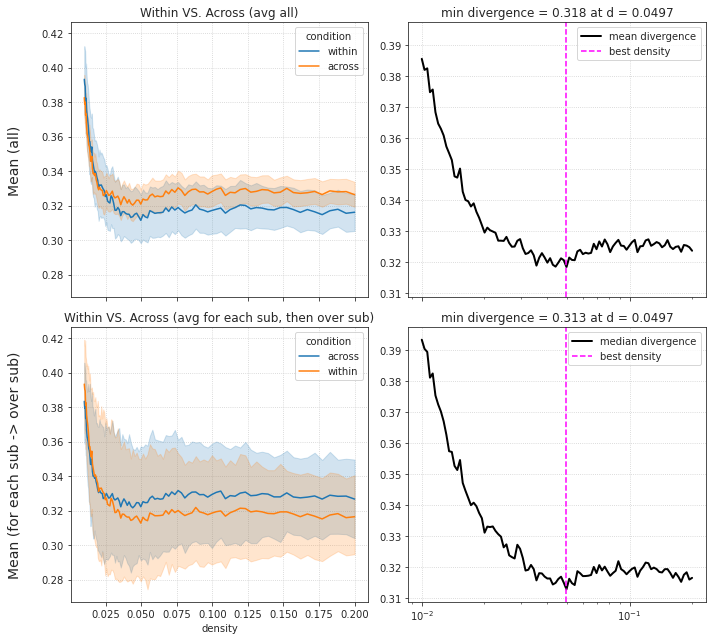

In [87]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df.loc[df['condition'] == 'within']
df_avg = df.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df,
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Within VS. Across (avg all)")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = _df.loc[_df['condition'] == 'within']
df_avg = df_avg.groupby(['density']).mean()
df_avg = df_avg['val']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=_df,
    x='density',
    y='val',
    hue='condition',
    estimator=np.mean,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Within VS. Across (avg for each sub, then over sub)")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.3f} at d = {best_d:0.4f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean (all)\n', fontsize=14)
axes[1, 0].set_ylabel('Mean (for each sub -> over sub)\n', fontsize=14)

plt.show()

#### tSNE on distance matrix

In [88]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(46, 0.04971769751868987)

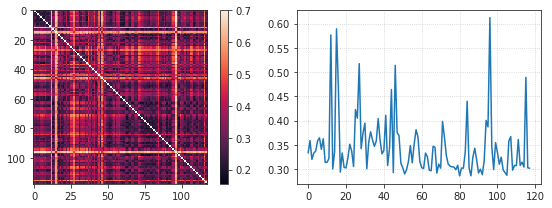

In [89]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T
np.fill_diagonal(x, np.nan)

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(bn.nanmean(x, 0))
axes[1].grid()
plt.show()

In [90]:
bad_runs_bold = np.argsort(bn.nanmean(x, 0))[::-1][:10]
bad_runs_bold = [list(dirs)[i] for i in bad_runs_bold]
bad_runs_bold

[
    'sub-SLC09_ses-1_run-5',
    'sub-SLC02_ses-1_run-7',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC03_ses-2_run-1',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC10_ses-3_run-3',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC04_ses-3_run-3',
    'sub-SLC08_ses-1_run-3',
    'sub-SLC03_ses-1_run-4'
]

In [91]:
from sklearn.manifold import TSNE, MDS

In [92]:
x[np.isnan(x)] = 0.

In [93]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [94]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
_df['sub'] = subs
_df['ses'] = sess
_df['run'] = runs

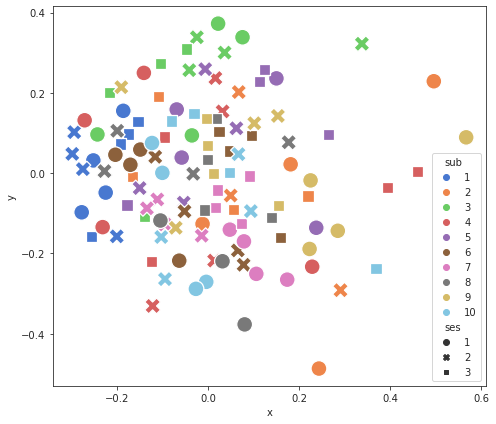

In [95]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='sub',
    palette='muted',
    style='ses',
    alpha=1.0,
    s=250,
    ax=ax,
)
plt.show()

In [96]:
x_emb = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [97]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
subs, sess, runs = list(zip(*[mice.looper[k] for k in dirs]))
_df['sub'] = subs
_df['ses'] = sess
_df['run'] = runs

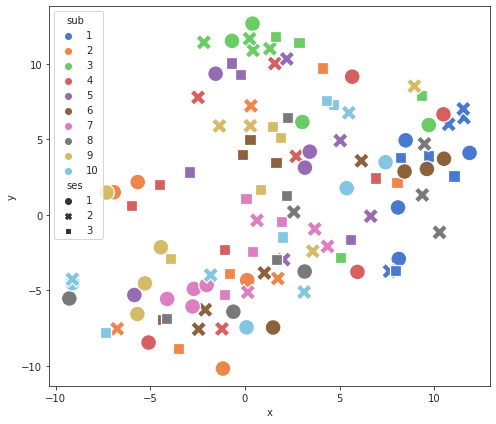

In [98]:
fig, ax = create_figure(1, 1, (7, 6))
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='sub',
    palette='muted',
    style='ses',
    alpha=1.0,
    s=250,
    ax=ax,
)
plt.show()